In [1]:
import os, sys
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from dotenv import load_dotenv
load_dotenv()

PROJECT_PATH = os.getenv('PROJECT_DIR')
sys.path.append(PROJECT_PATH)

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# visualization
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
from src.data_ingestion.iex_data import IexDataFetcher
from src.data_ingestion.weather_data import WeatherDataFetcher
from src.feature_engineering.build_features import FeatureEngineering
from src.model_building.forecast_model import ModelForecaster
from src.db_insertion.db_insertion import DAMInsertion
from src.utils import *
from config.paths import *

In [4]:
market_type = 'dam'

In [5]:
# creating instances
iex_data = IexDataFetcher()
weather_data = WeatherDataFetcher()

featured_data = FeatureEngineering(PROJECT_PATH)
forecasting = ModelForecaster(MODELS_PATH, market_type) 
db_insert = DAMInsertion() 

In [6]:
dam = iex_data._get_processed_data('dam')
rtm = iex_data._get_processed_data('rtm')
# weather = weather_data._get_processed_weather('weather')
# wind = weather_data._get_processed_weather('wind')
# hydro = weather_data._get_processed_weather('hydro')
# solar = weather_data._get_processed_weather('solar')

dam data updated up to:  17-01-2024 23:45
rtm data updated up to:  16-01-2024 18:45


In [7]:
dam = load_pickle(PROCESSED_DATA_PATH, 'dam_data')
rtm = load_pickle(PROCESSED_DATA_PATH, 'rtm_data')
weather = load_pickle(PROCESSED_DATA_PATH, 'weather_data')
wind = load_pickle(PROCESSED_DATA_PATH, 'wind_data')
hydro = load_pickle(PROCESSED_DATA_PATH, 'hydro_data')
solar = load_pickle(PROCESSED_DATA_PATH, 'solar_data')

In [6]:
rtm = featured_data.shift_date(rtm, 1) 
weather = featured_data.shift_date(weather, -1)
hydro = featured_data.shift_date(hydro, -1) 
solar = featured_data.shift_date(solar, -1) 
wind = featured_data.shift_date(wind, -1)

data = featured_data.merge_dataframes([dam, rtm, weather, hydro, solar, wind])

In [7]:
data = featured_data._get_features(data, weather, market_type, task = 'inference')

In [9]:
forecast_date = forecasting.forecasting_date(data, market_type)

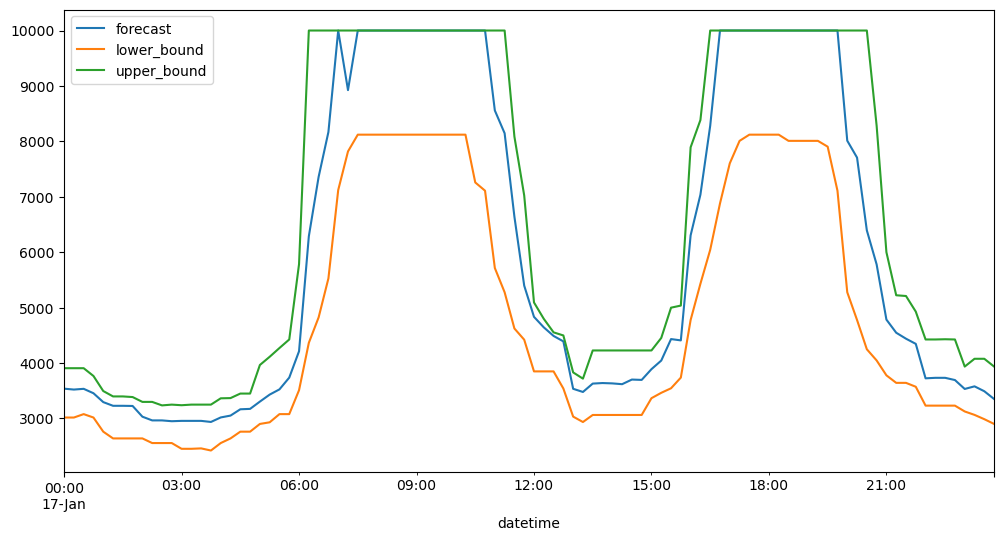

In [11]:
forecast = forecasting.create_forecast(data, forecast_date)

In [12]:
forecast

,datetime,forecast,lower_bound,upper_bound
0,2024-01-17 00:00:00,3535.2,3014.3,3904.8
1,2024-01-17 00:15:00,3519.2,3014.3,3904.8
2,2024-01-17 00:30:00,3532.4,3075.9,3904.8
3,2024-01-17 00:45:00,3452.8,3014.3,3764.2
4,2024-01-17 01:00:00,3292.8,2759.2,3492.5
...,...,...,...,...
91,2024-01-17 22:45:00,3691.0,3229.0,4423.4
92,2024-01-17 23:00:00,3530.1,3123.8,3934.2
93,2024-01-17 23:15:00,3577.2,3062.2,4074.8
94,2024-01-17 23:30:00,3488.8,2984.7,4074.8


In [10]:
db_insert.save_forecast(forecast,  forecast_date, 'forecast')

forecast data not inserted


In [11]:
db_insert.save_forecast(forecast,  forecast_date, 'lower_bound')

lower_bound data inserted successfully


In [12]:
db_insert.save_forecast(forecast,  forecast_date, 'upper_bound')

upper_bound data inserted successfully
